# Lane Detection Using OpenCV

The purpose of this notebook is to explore common `OpenCV` functions and dig into the fundamentals of autonomous vehicles, starting with lane detection.

## Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

## Reading Images

Read in an image showing an example of highway driving with an approaching curve.

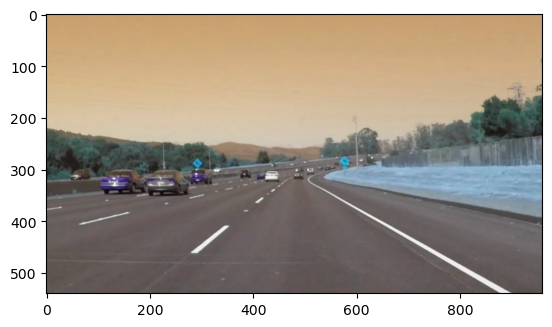

In [2]:
img = cv2.imread('test_images/solidWhiteCurve.jpg')
plt.imshow(img)

## Functions

In [3]:
def canny(img, kernal:tuple=(5, 5), low_thresh:int=50, upper_thresh:int=150):
    """Applies grayscale transformation, Gaussian blur,
    and then canny edge detection to the supplied image.
    Returns the final canny image."""
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    canny = cv2.Canny(blur, low_thresh, upper_thresh)
    return canny


def roi(img, points):
    """Returns a mask of specified points to apply to the
    image to create a region of interest."""
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, points, 255)
    masked_img = cv2.bitwise_and(img, mask)
    return masked_img


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def hough_lines(img, rho, theta, thresh, min_len, max_gap):
    lines = cv2.HoughLinesP(
        img, 
        rho, 
        theta, 
        thresh, 
        np.array([]), 
        minLineLength = min_len, 
        maxLineGap = max_gap
    )
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


def weighted_image(orig_img, hough_img, alpha, beta, gamma):
    return cv2.addWeighted(orig_img, alpha, hough_img, beta, gamma)

## Transformations

### Canny Edge Detection

The first step in the lane detection problem is to identify the edges, or boundries, of the features in our image. Specifically, we want to see if we can find the edges of the lines on the road. Canny edge detection is a fundamental method of edge detection that is based on the idea of calculating the gradient between subsequent pixel intensities.

First we can convert the image to multi-channel into single-channel by applying a grayscale transformation as we want to focus on the average intensity instead of a color-specific intensity of a pixel.

Next a Gaussian filter is applied to reduce the noise in the image and make the gradient calculation less susceptible to noise.

A **Sobel kernal** is then applied vertically and horizontally to calculate the first derivatives. The resulting two derived images allow us to apply the edge gradient calculation.

The image is then scanned to find the local neighbourhood maximum in the vertical and horizontal directions. All pixels aside from the pixels associated with the local maxima are then dropped, leaving an image with a black background and white lines corresponding to the edges.

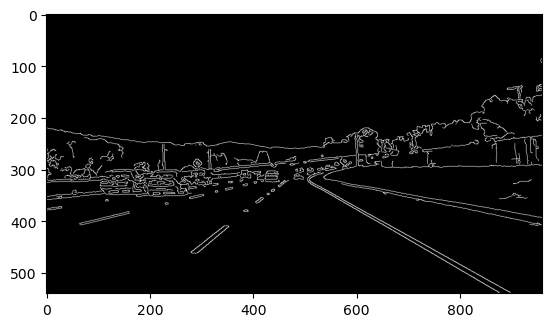

In [4]:
canny_img = canny(np.copy(img), low_thresh=25, upper_thresh=100)
plt.imshow(canny_img, cmap='gray')

### Region of Interest

In the final product, we do not want to display the edges of every single object/feature in our image, we only want to focus on the lines on the road. To help us achieve this, the image can be masked such that only the road ahead is considered for land detection and the edges to the sides are ignored.

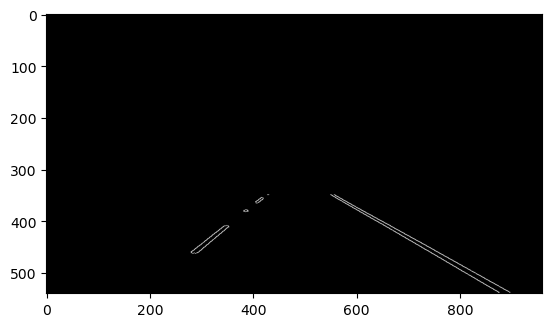

In [5]:
height = canny_img.shape[0]
points = np.array([[
    (150, height), (400, 350), (600, 350), (900, height)
]])

roi_canny_img = roi(canny_img, points)
plt.imshow(roi_canny_img, cmap='gray')

### Hough Lines

Great, so now we have the edged of the lane markers on the road only for the lane the vehicle is in. However, the edges alone cannot describe the idea of _lanes_. Lanes can be seperated by solid lines, dashed lines, etc. So far we just know where the edges of theses lines are, what we want to do is draw a line over these edges to describe the left and right boundried of the lane.



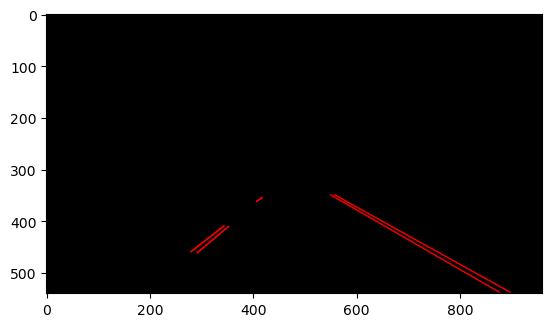

In [6]:
hough_img = hough_lines(roi_canny_img, 2, np.pi/180, 100, 10, 5)
plt.imshow(hough_img)

### Weighted Addition

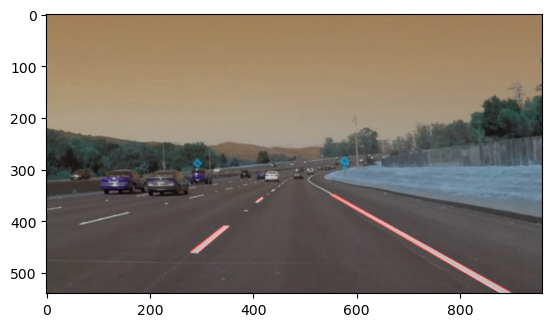

In [11]:
lane_img = np.copy(img)
# weighted_img = weighted_image(lane_img, hough_img, 0.8, 1.0, 0)

test = cv2.addWeighted(lane_img, 0.8, hough_img, 1.0, 0)
plt.imshow(test)